In [2]:
import sys
import os
sys.path.insert(0, os.path.abspath("../src"))

/usr/local/Caskroom/miniconda/base/envs/qiskit-env/lib/python3.10/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/Caskroom/miniconda/base/envs/qiskit-env/lib/python3.10/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


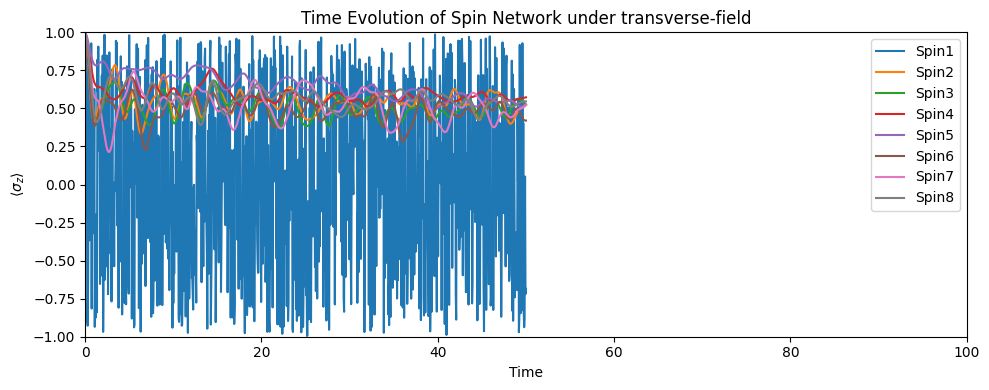

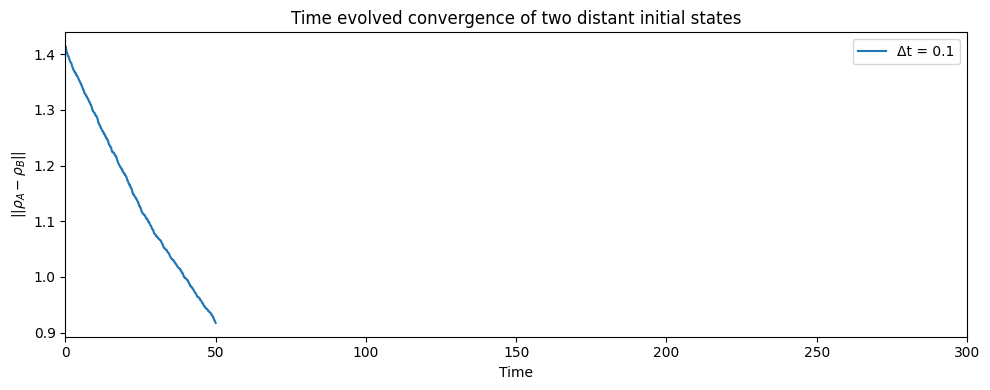

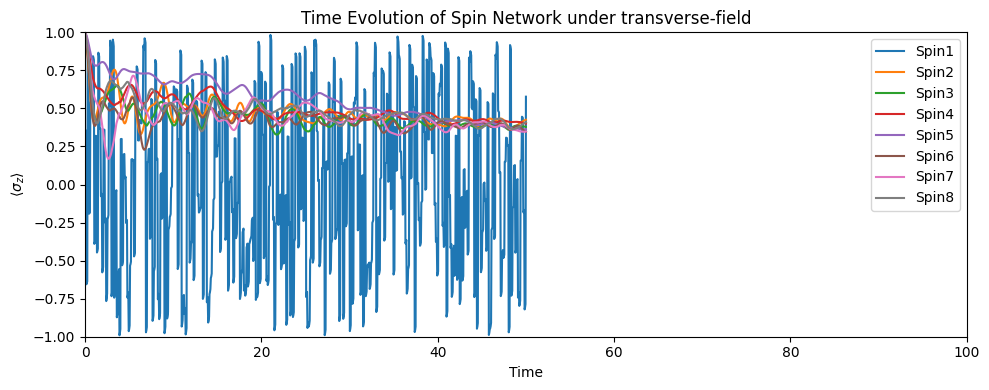

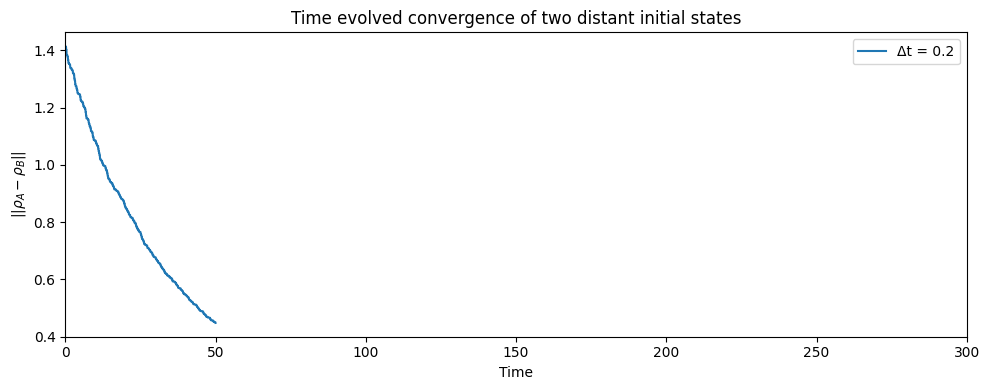

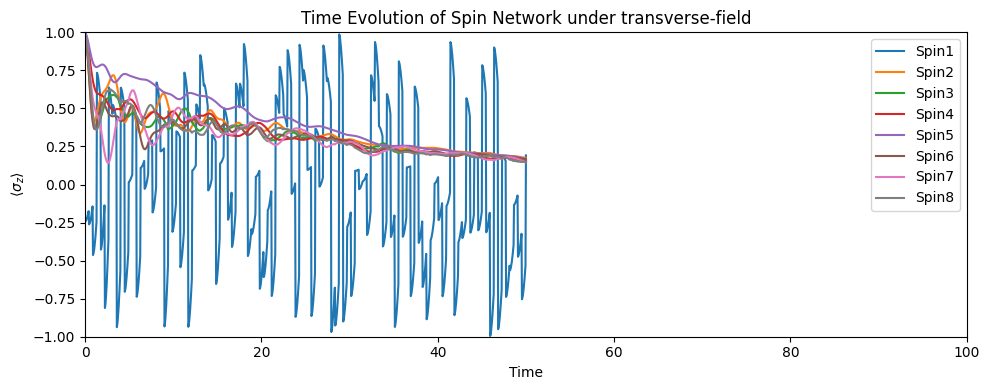

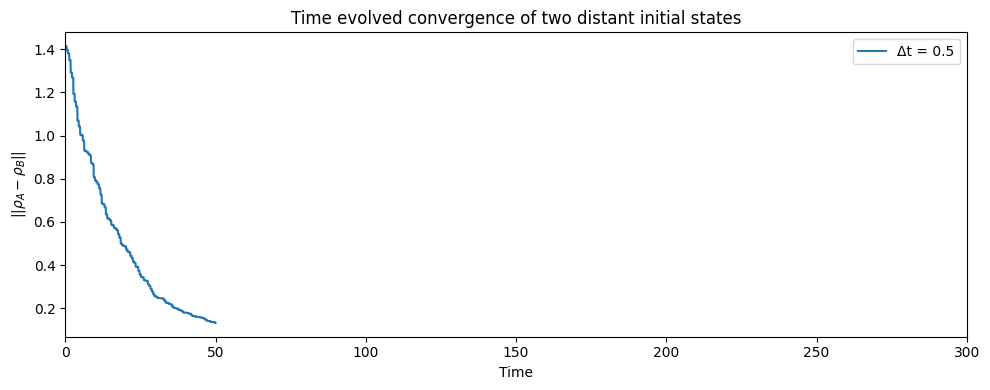

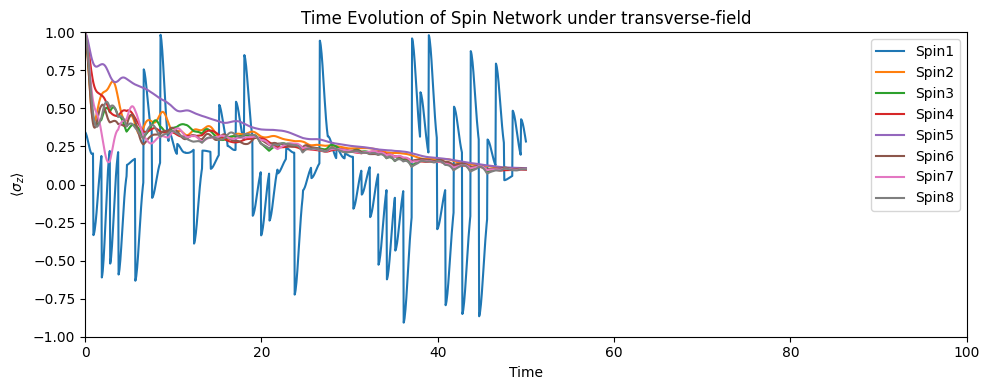

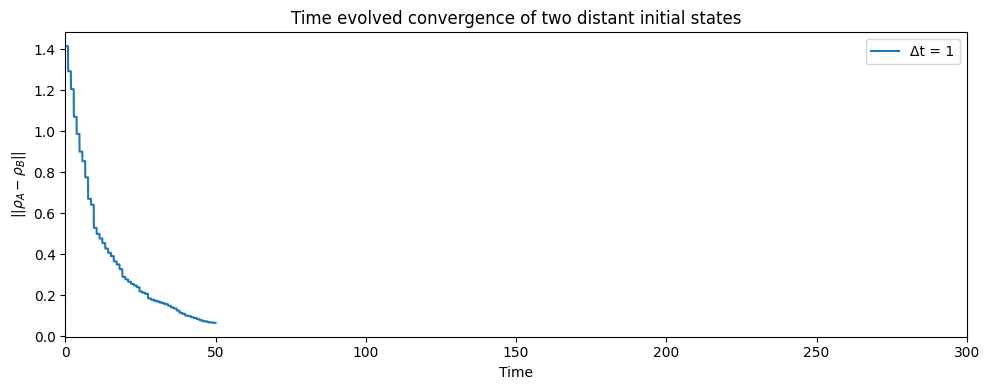

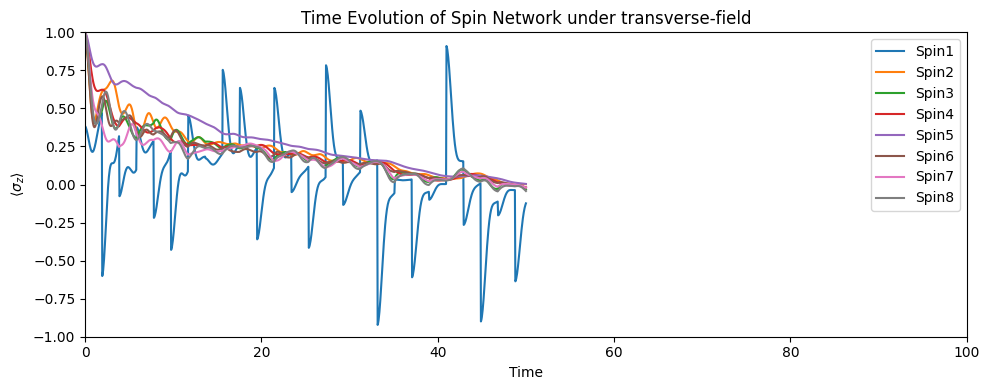

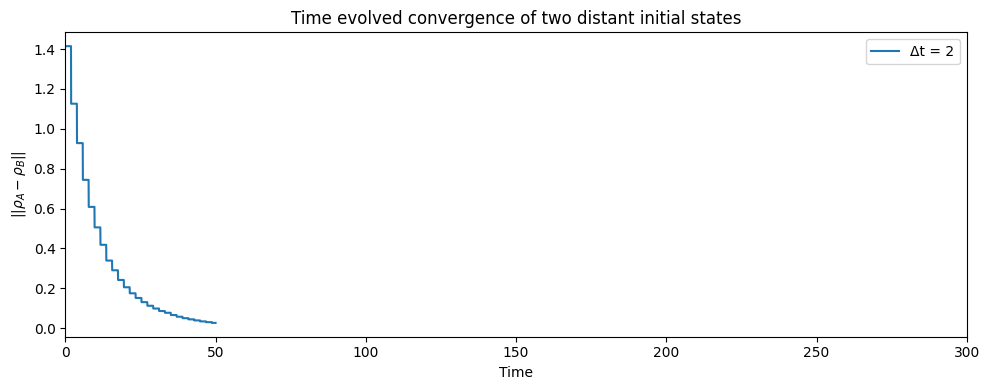

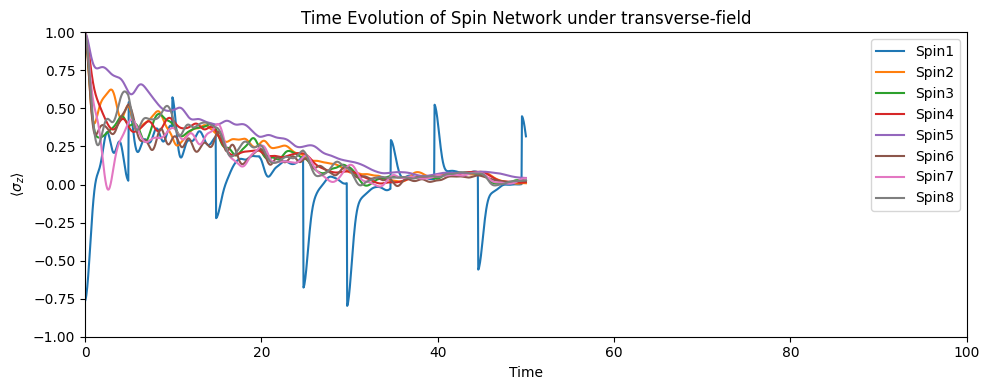

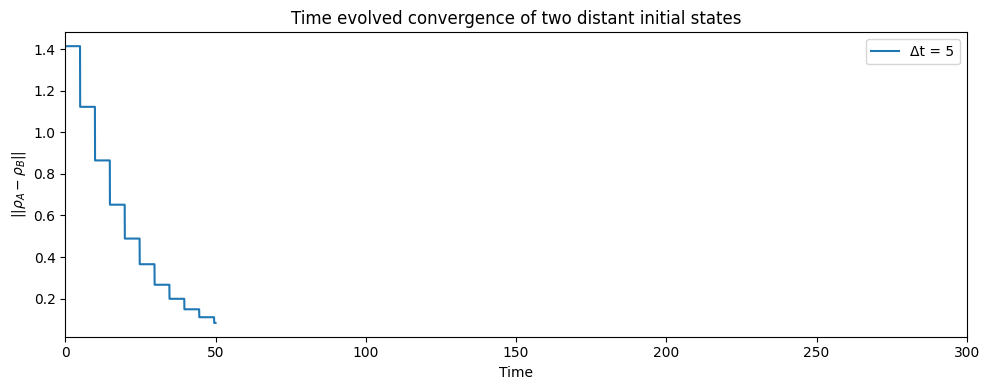

STM: 0.005-0.000j, PC: 0.007-0.000j, NMSE: 0.000+0.000j


In [39]:
import numpy as np
from qrc.core.qrc_system import QRCSystem
from qrc.analysis.memory_capacity import calculate_stm
from qrc.analysis.parity_capacity import calculate_pc
from qrc.analysis.nmse import calculate_nmse
from qrc.analysis.entanglement import von_neumann_entropy, purity
from qrc.visualization.plot_results import plot_observables, plot_distance


# Parameters for the QRC system
num_spins = 8
tlist = np.linspace(0, 50, 1000)
delta_t_list = [0.1, 0.2, 0.5, 1, 2, 5]
qrc = QRCSystem(num_spins=num_spins, h=0.5, Js=1, dt=tlist[1]-tlist[0], seed=42)

# Run QRC simulation and trials for different delta_t values
expectation_values, distance_values, x_values, rho_histories = qrc.run_trials(tlist, delta_t_list)

# Visualize results
for trial in range(len(delta_t_list)):
    plot_observables(
        tlist,
        [expectation_values[trial][j] for j in range(num_spins)],
        num_spins
    )
    plot_distance(
        tlist,
        [distance_values[trial]],
        [delta_t_list[trial]]
    )

# Compute STM、PC、NMSE（take first trial、first qubit as example）
x = np.array(x_values[0][0])
y = np.array(expectation_values[0][0][:len(x)])  # 截斷 y 長度與 x 一致

stm = calculate_stm(x, y, max_delay=10)
pc = calculate_pc(x, y, max_delay=10)
nmse = calculate_nmse(x, y)

print(f"STM: {stm:.3f}, PC: {pc:.3f}, NMSE: {nmse:.3f}")

delta_t=0.1: STM=0.005-0.000j, PC=0.007-0.000j, NMSE=0.000+0.000j
delta_t=0.2: STM=0.049+0.000j, PC=0.052+0.000j, NMSE=2.148-0.000j
delta_t=0.5: STM=0.085+0.000j, PC=0.044-0.000j, NMSE=1.792+0.000j
delta_t=1: STM=0.081+0.000j, PC=0.174+0.000j, NMSE=1.378-0.000j
delta_t=2: STM=0.375-0.000j, PC=0.740-0.000j, NMSE=1.315+0.000j
delta_t=5: STM=2.189-0.000j, PC=2.498-0.000j, NMSE=2.263+0.000j


/usr/local/Caskroom/miniconda/base/envs/qiskit-env/lib/python3.10/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/Caskroom/miniconda/base/envs/qiskit-env/lib/python3.10/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/Caskroom/miniconda/base/envs/qiskit-env/lib/python3.10/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/local/Caskroom/miniconda/base/envs/qiskit-env/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/Caskroom/miniconda/base/envs/qiskit-env/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


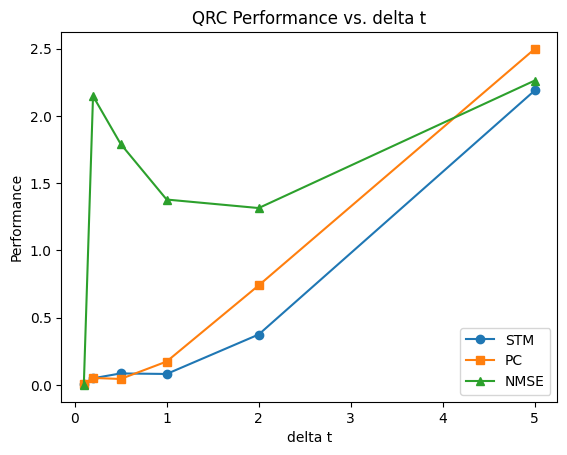

In [40]:
# Analyze cases for all delta t
stm_list, pc_list, nmse_list = [], [], []
for trial in range(len(delta_t_list)):
    x = np.array(x_values[trial][0])
    y = np.array(expectation_values[trial][0][:len(x)])
    stm = calculate_stm(x, y, max_delay=10)
    pc = calculate_pc(x, y, max_delay=10)
    nmse = calculate_nmse(x, y)
    stm_list.append(stm)
    pc_list.append(pc)
    nmse_list.append(nmse)
    print(f"delta_t={delta_t_list[trial]}: STM={stm:.3f}, PC={pc:.3f}, NMSE={nmse:.3f}")

# Plot delta t vs STM/PC/NMSE
import matplotlib.pyplot as plt
plt.figure()
plt.plot(delta_t_list, stm_list, 'o-', label='STM')
plt.plot(delta_t_list, pc_list, 's-', label='PC')
plt.plot(delta_t_list, nmse_list, '^-', label='NMSE')
plt.xlabel('delta t')
plt.ylabel('Performance')
plt.legend()
plt.title('QRC Performance vs. delta t')
plt.show()

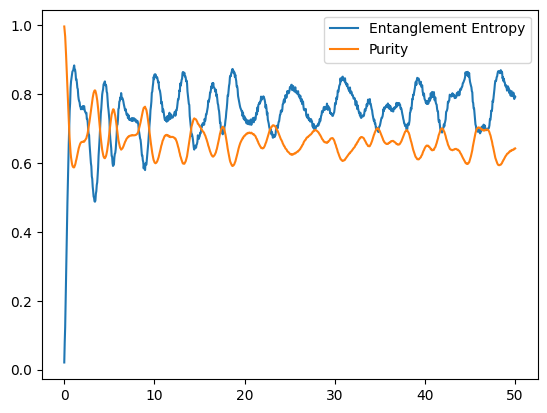

In [41]:
# Analyze entanglement and purityfor the first trial
entropy_list = []
purity_list = []
for rho in rho_histories[0]:
    # Trace out the first two qubits
    rho_sub = rho.ptrace([0, 1])
    entropy_list.append(von_neumann_entropy(rho_sub))
    purity_list.append(purity(rho_sub))

plt.plot(tlist, entropy_list, label="Entanglement Entropy")
plt.plot(tlist, purity_list, label="Purity")
plt.legend()
plt.show()

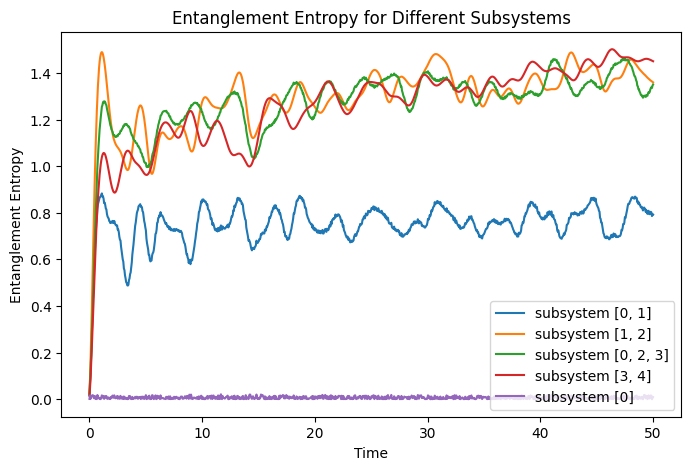

In [42]:
# Analyze entanglement entropy for different subsystems in the first trial

subsystems = [
    [0, 1],        # qubit 0,1
    [1, 2],        # qubit 1,2
    [0, 2, 3],     # qubit 0,2,3
    [3, 4],        # qubit 3,4
    [0],           # single qubit
]

entropy_dict = {str(sub): [] for sub in subsystems}

for rho in rho_histories[0]:  # Analyze the first trial
    for sub in subsystems:
        rho_sub = rho.ptrace(sub)
        entropy_dict[str(sub)].append(von_neumann_entropy(rho_sub))

import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
for sub in subsystems:
    plt.plot(tlist, entropy_dict[str(sub)], label=f"subsystem {sub}")
plt.xlabel("Time")
plt.ylabel("Entanglement Entropy")
plt.title("Entanglement Entropy for Different Subsystems")
plt.legend()
plt.show()

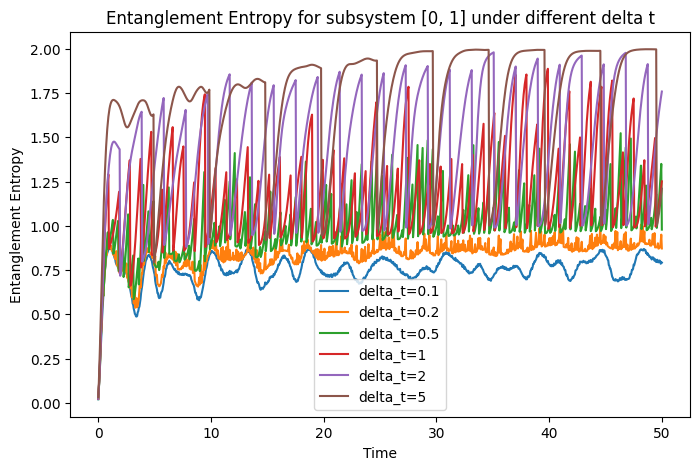

In [43]:
sub = [0, 1]  # The subsystem you want to analyze
plt.figure(figsize=(8,5))
for trial, delta_t in enumerate(delta_t_list):
    entropy_list = []
    for rho in rho_histories[trial]:
        rho_sub = rho.ptrace(sub)
        entropy_list.append(von_neumann_entropy(rho_sub))
    plt.plot(tlist, entropy_list, label=f"delta_t={delta_t}")
plt.xlabel("Time")
plt.ylabel("Entanglement Entropy")
plt.title(f"Entanglement Entropy for subsystem {sub} under different delta t")
plt.legend()
plt.show()

/usr/local/Caskroom/miniconda/base/envs/qiskit-env/lib/python3.10/site-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


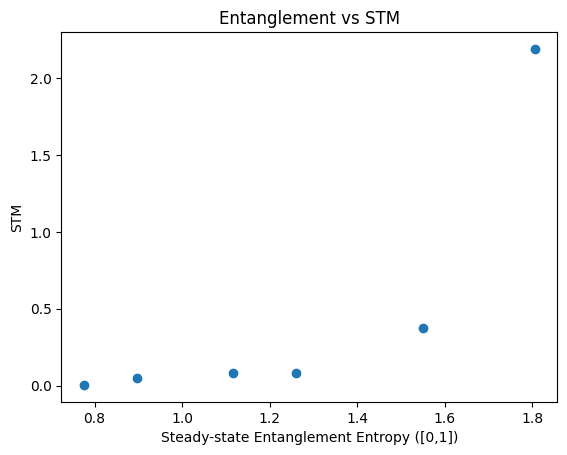

In [44]:
# With stm_list, pc_list, nmse_list
avg_entropies = []
for trial in range(len(delta_t_list)):
    entropy_list = []
    for rho in rho_histories[trial]:
        rho_sub = rho.ptrace([0, 1])
        entropy_list.append(von_neumann_entropy(rho_sub))
    avg_entropies.append(np.mean(entropy_list[-100:]))
plt.figure()
plt.scatter(avg_entropies, stm_list)
plt.xlabel("Steady-state Entanglement Entropy ([0,1])")
plt.ylabel("STM")
plt.title("Entanglement vs STM")
plt.show()

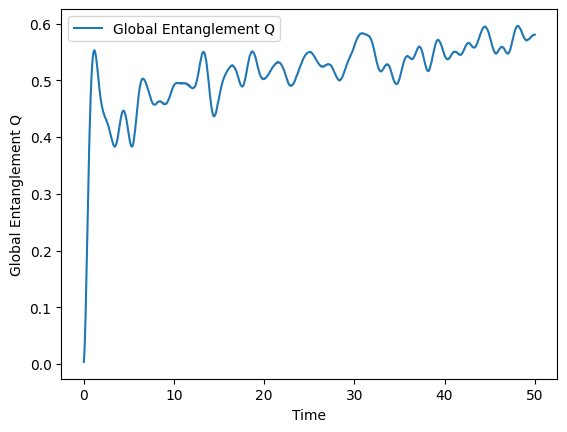

In [45]:
from qrc.analysis.entanglement import global_entanglement

# 以第一個 trial 為例
global_ent = []
for rho in rho_histories[0]:
    global_ent.append(global_entanglement(rho, num_spins))

import matplotlib.pyplot as plt
plt.plot(tlist, global_ent, label="Global Entanglement Q")
plt.xlabel("Time")
plt.ylabel("Global Entanglement Q")
plt.legend()
plt.show()

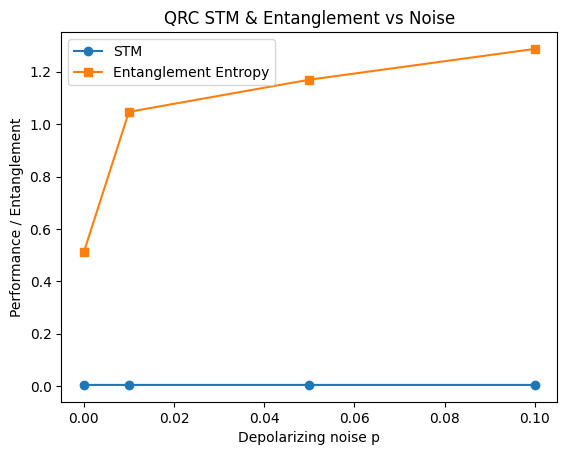

In [29]:
noise_p_list = [0.0, 0.01, 0.05, 0.1]
stm_vs_noise = []
ent_vs_noise = []

for noise_p in noise_p_list:
    qrc = QRCSystem(num_spins=5, h=1, Js=1, dt=tlist[1]-tlist[0], seed=42, noise_p=noise_p)
    expectation_values, distance_values, x_values, rho_histories = qrc.run_trials(tlist, delta_t_list)
    # 以第一個 trial、第一個 qubit 為例
    x = np.array(x_values[0][0])
    y = np.array(expectation_values[0][0][:len(x)])
    stm = calculate_stm(x, y, max_delay=10)
    stm_vs_noise.append(stm)
    # 取穩態糾纏熵
    entropy_list = [von_neumann_entropy(rho.ptrace([0,1])) for rho in rho_histories[0]]
    ent_vs_noise.append(np.mean(entropy_list[-100:]))

import matplotlib.pyplot as plt
plt.figure()
plt.plot(noise_p_list, stm_vs_noise, 'o-', label='STM')
plt.plot(noise_p_list, ent_vs_noise, 's-', label='Entanglement Entropy')
plt.xlabel('Depolarizing noise p')
plt.ylabel('Performance / Entanglement')
plt.legend()
plt.title('QRC STM & Entanglement vs Noise')
plt.show()

1. NARMA Task

Steps

Produce NARMA input sequences and target sequences

Use QRC output（eg. x_values）as features

Use linear regression(or Ridge) to train the output layer

Compute NMSE

In [46]:
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

# 產生 NARMA10 輸入與目標
def generate_narma10(length):
    u = np.random.rand(length)
    y = np.zeros(length)
    y[:10] = 0.1  # to avoid initial zero
    for t in range(10, length):
        y[t] = 0.3*y[t-1] + 0.05*y[t-1]*np.sum(y[t-10:t]) + 1.5*u[t-10]*u[t-1] + 0.1
    y = np.clip(y, -1e3, 1e3)  # to avoid explosion    
    return u, y

length = 1000
u, y_target = generate_narma10(length)

# 用 u 當 QRC 輸入，跑 QRC
qrc = QRCSystem(num_spins=5, h=1, Js=1, dt=tlist[1]-tlist[0], seed=42, noise_p=0.0)
# 假設你有一個 run_trials_for_input(tlist, delta_t_list, input_seq) 可用
expectation_values, distance_values, x_values, rho_histories = qrc.run_trials(tlist, delta_t_list, input_seq=u)

# first trial, multiple qubits
num_features = len(x_values[0])  # actual number of qubits used
X = np.stack([np.array(x_values[0][j]).real for j in range(num_features)], axis=1)
y = y_target[:len(X)]

ridge = Ridge(alpha=1e-2)
ridge.fit(X, y)
y_pred = ridge.predict(X)
nmse = mean_squared_error(y, y_pred) / np.var(y)
print("NARMA10 NMSE:", nmse)

/var/folders/c3/sld2jf_555vgb5t01vk42w8h0000gn/T/ipykernel_75699/3457768248.py:11: RuntimeWarning: overflow encountered in scalar multiply
  y[t] = 0.3*y[t-1] + 0.05*y[t-1]*np.sum(y[t-10:t]) + 1.5*u[t-10]*u[t-1] + 0.1


NARMA10 NMSE: 0.901706558635629


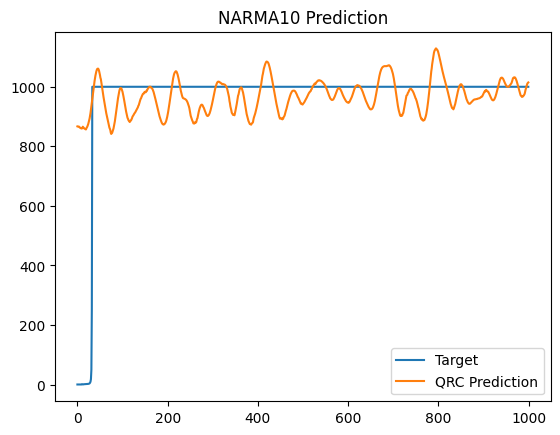

In [47]:
plt.plot(y, label='Target')
plt.plot(y_pred, label='QRC Prediction')
plt.legend()
plt.title('NARMA10 Prediction')
plt.show()

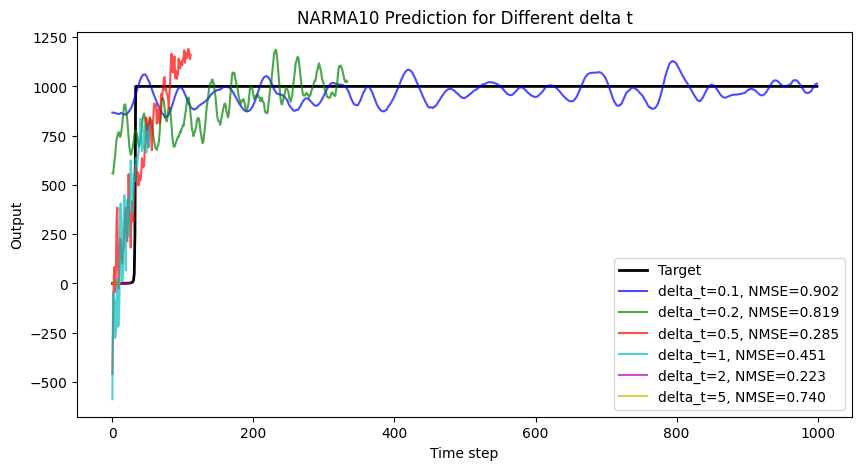

In [48]:
delta_t_list = [0.1, 0.2, 0.5, 1, 2, 5]
colors = ['b', 'g', 'r', 'c', 'm', 'y']
plt.figure(figsize=(10,5))
plt.plot(y_target[:len(x_values[0][0])], label='Target', color='k', linewidth=2)

for i, delta_t in enumerate(delta_t_list):
    num_features = len(x_values[i])  # catch the number of qubits used in each trial
    X = np.stack([np.array(x_values[i][j]).real for j in range(num_features)], axis=1)
    y = y_target[:len(X)]
    ridge = Ridge(alpha=1e-2)
    ridge.fit(X, y)
    y_pred = ridge.predict(X)
    nmse = mean_squared_error(y, y_pred) / np.var(y)
    plt.plot(y_pred, label=f'delta_t={delta_t}, NMSE={nmse:.3f}', color=colors[i], alpha=0.7)

plt.legend()
plt.title('NARMA10 Prediction for Different delta t')
plt.xlabel('Time step')
plt.ylabel('Output')
plt.show()